In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/sohee/.local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import itertools
from itertools import groupby
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [4]:
from load_data import load_data,class_breakdown

In [5]:
#data_name ="EEG"
data_name ="HAR"

#data_name ="UWaveGestureLibraryAll"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data HAR
batch size:64
train data (7352, 128, 9),(7352, 1)
test data (2947, 128, 9),(2947, 1)


In [6]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


In [7]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (7352, 6)
y test shape: (2947, 6)


## 데이터 정규화

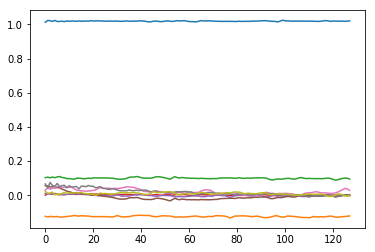

In [8]:
plt.plot(trainx[0])

In [9]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

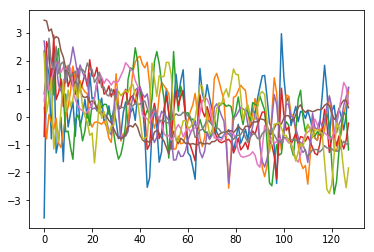

In [10]:
plt.plot(trainx[0])

In [11]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(7352, 1, 128, 9)
trainY shape:(7352, 6)
validX shape:(1473, 1, 128, 9)
validY shape:(1473, 6)
testX shape:(1474, 1, 128, 9)
testY shape:(1474, 6)


In [12]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 128
input_channel 9


# 2. Training condition 정의

In [13]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 300


std= 0.01
l_rate = 1e-5

In [14]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [15]:
from FCN import CNN_MC_dropout, CNN_MC_dropout_last_conv_turnoff

/home/sohee/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sohee/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sohee/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sohee/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [16]:
import tensorflow as tf

In [17]:
class conv3_basic_CNN:
    def __init__(self, featuremap1, featuremap2, featuremap3,
                 conv1_size, conv2_size, conv3_size,
                 conv1_stride, conv2_stride, conv3_stride, 
                 conv1_channel, conv2_channel, conv3_channel,
                 pool1_size, pool2_size, pool3_size,
                 pool1_stride, pool2_stride, pool3_stride,
                 std=0.01, batch_size=64,width=500, height =1, input_channel=3, 
                 nb_classes=2, l_rate =1e-6,
                 reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.feature1 = featuremap1
        self.feature2 = featuremap2
        self.feature3 = featuremap3
        
        self.conv1_size = conv1_size
        self.conv2_size = conv2_size
        self.conv3_size = conv3_size
        
        self.conv1_stride = conv1_stride
        self.conv2_stride = conv2_stride
        self.conv3_stride = conv3_stride
        
        self.conv1_channel = conv1_channel
        self.conv2_channel = conv2_channel
        self.conv3_channel = conv3_channel
        
        self.pool1_size = pool1_size
        self.pool2_size = pool2_size
        self.pool3_size = pool3_size
        
        self.pool1_stride = pool1_stride
        self.pool2_stride = pool2_stride
        self.pool3_stride = pool3_stride
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32,name="keep_probability")
            
            self.threshold_weight1 = tf.placeholder(tf.float32, [None, self.height,self.feature1, self.conv1_channel],name="threshold_weight1")
            self.threshold_weight2 = tf.placeholder(tf.float32, [None, self.height,self.feature2, self.conv2_channel],name="threshold_weight2")
            self.threshold_weight3 = tf.placeholder(tf.float32, [None, self.height,self.feature3, self.conv3_channel],name="threshold_weight3")
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.prediction,1),tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, self.conv1_channel, [1,self.conv1_size], padding='SAME', strides=[1,self.conv1_stride])
            self.pooling1 = tf.layers.max_pooling2d(inputs=self.conv1, pool_size=[1, self.pool1_size],padding="VALID", strides=[1,self.pool1_stride])
            self.batch1 = tf.layers.batch_normalization(self.pooling1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.threshold_relu1 = tf.multiply(self.relu1 , self.threshold_weight1)
            self.dropout1 = tf.nn.dropout(self.threshold_relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, self.conv2_channel, [1,self.conv2_size], padding='SAME', strides=[1,self.conv2_stride])
            self.pooling2 = tf.layers.max_pooling2d(inputs=self.conv2, pool_size=[1, self.pool2_size] ,padding="VALID", strides=[1,self.pool2_stride])                                        
            self.batch2 = tf.layers.batch_normalization(self.pooling2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.threshold_relu2 = tf.multiply(self.relu2 , self.threshold_weight2)
            self.dropout2 = tf.nn.dropout(self.threshold_relu2, self.keep_prob)

        #Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, self.conv3_channel, [1,self.conv3_size], padding='SAME', strides=[1,self.conv3_stride])
            self.pooling3 = tf.layers.max_pooling2d(inputs=self.conv3, pool_size=[1, self.pool3_size] ,padding="VALID", strides=[1,self.pool3_stride]) 
            self.batch3 = tf.layers.batch_normalization(self.pooling3)
            self.relu3 = tf.nn.relu(self.batch3)
            self.threshold_relu3 = tf.multiply(self.relu3 , self.threshold_weight3)
            self.dropout3 = tf.nn.dropout(self.threshold_relu3, self.keep_prob)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            self.flatten = tf.reshape(self.dropout3, [-1, int(self.dropout3.shape[2]) * self.conv3_channel],name='flatten') 
            #self.dense1 = tf.layers.dense(inputs=self.flatten,
            #                         units=128, activation=tf.nn.relu)   
            #Global Average Pooling
            #self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.flatten,self.nb_classes,name='logits')
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob):
        opt, cost ,acc = self.sess.run((self.optimizer,self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.threshold_weight1: np.ones(data.shape[0]*int(self.relu1.shape[2])*self.conv1_channel).reshape(-1,1,int(self.relu1.shape[2]),self.conv1_channel).astype(float),
                                       self.threshold_weight2: np.ones(data.shape[0]*int(self.relu2.shape[2])*self.conv2_channel).reshape(-1,1,int(self.relu2.shape[2]),self.conv2_channel).astype(float),
                                       self.threshold_weight3: np.ones(data.shape[0]*int(self.relu3.shape[2])*self.conv3_channel).reshape(-1,1,int(self.relu3.shape[2]),self.conv3_channel).astype(float)})
        return cost,acc

    def test(self, data, target, keep_prob,threshold_weight1, threshold_weight2, threshold_weight3):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                        self.keep_prob : keep_prob,
                                        self.threshold_weight1: threshold_weight1,
                                        self.threshold_weight2: threshold_weight2,
                                        self.threshold_weight3: threshold_weight3})
        return cost,acc

    def get_output(self, output,data, keep_prob,threshold_weight1, threshold_weight2, threshold_weight3):
        output =  self.sess.run((output), 
                                     feed_dict={self.x: data,self.keep_prob: keep_prob,
                                                self.threshold_weight1: threshold_weight1,
                                                self.threshold_weight2: threshold_weight2,
                                                self.threshold_weight3: threshold_weight3})
        return output
    
    def predict(self, data, keep_prob,threshold_weight1, threshold_weight2,threshold_weight3):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,self.keep_prob: keep_prob,
                                        self.threshold_weight1: threshold_weight1,
                                        self.threshold_weight2: threshold_weight2,
                                        self.threshold_weight3: threshold_weight3})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph()

In [18]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

6


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

<font color='blue'> CNN_MC_dropout_last_conv_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output을 0으로 turn off 시키는 구조입니다.

반면, <font color='blue'> CNN_MC_dropout_input_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output에 매칭되는(하이라이트 되는 인풋)을 0으로 turn off 시키는 구조입니다.

In [19]:
import math
if data_name in ["HAR","EEG"]:
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 7
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 4
    pool1_pad = 0
    pool1_stride = 2

    ###### conv2
    conv2_size = 5
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 3
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 2
    pool3_pad = 0
    pool3_stride = 1
elif data_name in "UWaveGestureLibraryAll":
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 15
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 8
    pool1_pad = 0
    pool1_stride = 4

    ###### conv2
    conv2_size = 11
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 7
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 4
    pool3_pad = 0
    pool3_stride = 2

In [20]:
# conv1_idx_list=[]
# for conv1_idx in range(0,trainX.shape[2],conv1_stride):
#     conv1_idx_list.append(np.arange(max(conv1_idx-(conv1_size//2),0), min(conv1_idx+(conv1_size//2) +1 ,trainX.shape[2])))

# if conv1_idx < (trainX.shape[2]-1):
#     for data_idx in np.arange(conv1_idx+1, trainX.shape[2]):
#         conv1_idx_list.append(data_idx)
    
# print(len(conv1_idx_list))



# pool1_idx_list=[]
# for pool1_idx in range(0,len(conv1_idx_list)-(pool1_size-1), pool1_stride):
#     temp_idx = []
#     for conv1_idx in np.arange(max(pool1_idx,0), min(pool1_idx+pool1_size ,len(conv1_idx_list))):
#         temp_idx.extend(conv1_idx_list[conv1_idx])
#     if set(temp_idx):
#         pool1_idx_list.append(list(set(temp_idx)))
        
# if (pool1_idx + pool1_size) < (len(conv1_idx_list)-1):
#     temp_idx = []
#     for conv1_idx in np.arange(pool1_idx+1, len(conv1_idx_list)):
#         temp_idx.extend(conv1_idx_list[conv1_idx])
#         pool1_idx_list.append(list(set(temp_idx)))
# print(len(pool1_idx_list))


# conv2_idx_list=[]
# for conv2_idx in range(0,len(pool1_idx_list), conv2_stride):
#     temp_idx = []
#     for pool1_idx in np.arange(max(conv2_idx-(conv2_size//2),0), min(conv2_idx+(conv2_size//2) +1 ,len(pool1_idx_list))):
#         temp_idx.extend(pool1_idx_list[pool1_idx])
#     if set(temp_idx):
#         conv2_idx_list.append(list(set(temp_idx)))

# if conv2_idx < (len(pool1_idx_list)-1):
#     print("add")
#     temp_idx = []
#     for pool1_idx in np.arange(conv2_idx+1, len(pool1_idx_list)):
#         conv2_idx_list.append(pool1_idx_list[pool1_idx])
# print(len(conv2_idx_list))




# pool2_idx_list=[]
# for pool2_idx in range(0,len(conv2_idx_list)-(pool2_size-1), pool2_stride):
#     temp_idx = []
#     for conv2_idx in np.arange(max(pool2_idx ,0), min(pool2_idx+pool2_size ,len(conv2_idx_list))):
#         temp_idx.extend(conv2_idx_list[conv2_idx])
#     pool2_idx_list.append(list(set(temp_idx)))

# if (pool2_idx + pool2_size-1) < (len(conv2_idx_list)-1):
#     print('add')
#     temp_idx = []
#     for conv2_idx in np.arange(pool2_idx+ pool2_size+1, len(conv2_idx_list)):
#         pool2_idx_list.append(conv2_idx_list[conv2_idx])
# print(len(pool2_idx_list))

# conv3_idx_list=[]
# for conv3_idx in range(0,len(pool2_idx_list), conv3_stride):
#     temp_idx = []
#     for pool2_idx in np.arange(max(conv3_idx-(conv3_size//2),0), min(conv3_idx+(conv3_size//2) +1 ,len(pool2_idx_list))):
#         temp_idx.extend(pool2_idx_list[pool2_idx])
#     if set(temp_idx):
#         conv3_idx_list.append(list(set(temp_idx)))

# if conv3_idx < (len(pool2_idx_list)-1):
#     print("add")
#     temp_idx = []
#     for pool2_idx in np.arange(conv3_idx+1, len(pool3_idx_list)):
#         conv3_idx_list.append(pool2_idx_list[pool2_idx])
# print(len(conv3_idx_list))



# pool3_idx_list=[]
# for pool3_idx in range(0,len(conv3_idx_list)-(pool3_size-1), pool3_stride):
#     temp_idx = []
#     for conv3_idx in np.arange(max(pool3_idx ,0), min(pool3_idx+pool3_size ,len(conv3_idx_list))):
#         temp_idx.extend(conv3_idx_list[conv3_idx])
#     pool3_idx_list.append(list(set(temp_idx)))

# if (pool3_idx + pool3_size-1) < (len(conv3_idx_list)-1):
#     print('add')
#     for conv3_idx in np.arange(pool3_idx+ pool3_size+1, len(conv3_idx_list)):
#         pool3_idx_list.append(conv3_idx_list[conv3_idx])
# print(len(pool3_idx_list))


In [21]:
# 원하는 층의 RF가 pattern_len이 됨
conv1_RF = 1+(conv1_size-1)
pool1_RF = conv1_RF+(pool1_size-1)*conv1_stride
jump1 = conv1_stride

conv2_RF = pool1_RF+(conv2_size-1)*conv1_stride*pool1_stride
pool2_RF = conv2_RF+(pool2_size-1)*conv1_stride*pool1_stride*conv2_stride
jump2 = conv1_stride*pool1_stride*conv2_stride

conv3_RF = pool2_RF+(conv3_size-1)*conv1_stride*pool1_stride*conv2_stride*pool2_stride
pool3_RF = conv3_RF+(pool3_size-1)*conv1_stride*pool1_stride*conv2_stride*pool2_stride*conv3_stride
jump3 = conv1_stride*pool1_stride*conv2_stride*pool2_stride*conv3_stride

conv1_output = math.floor((trainX.shape[2]-conv1_size+2*conv1_pad)/conv1_stride)+1
pool1_output = math.floor((conv1_output-pool1_size+(2*pool1_pad))/pool1_stride)+1 
conv2_output = math.floor((pool1_output-conv2_size+(2*conv2_pad))/conv2_stride)+1 
pool2_output = math.floor((conv2_output-pool2_size+(2*pool2_pad))/pool2_stride)+1 
conv3_output = math.floor((pool2_output-conv3_size+(2*conv3_pad))/conv3_stride)+1 
pool3_output = math.floor((conv3_output-pool3_size+(2*pool3_pad))/pool3_stride)+1

zero_padding3 =  (jump3 * (pool3_output -1 )) + pool3_RF- trainX.shape[2]
R_pad3 = math.floor(zero_padding3/2)
L_pad3 = math.ceil(zero_padding3/2)

zero_padding2 =  (jump2 * (pool2_output -1 )) + pool2_RF- trainX.shape[2]
R_pad2 = math.floor(zero_padding2/2)
L_pad2 = math.ceil(zero_padding2/2)

zero_padding1 =  (jump1 * (pool1_output -1 )) + pool1_RF- trainX.shape[2]
R_pad1 = math.floor(zero_padding1/2)
L_pad1 = math.ceil(zero_padding1/2)

pool3_idx_list = []
for x in np.arange(-R_pad3, trainX.shape[2]+L_pad3, jump3):
    if x + pool3_RF < trainX.shape[2]+ L_pad3 +1:
        pool3_idx_list.append(np.arange(x,x+pool3_RF))
        
pool2_idx_list = []
for x in np.arange(-R_pad2, trainX.shape[2]+L_pad2, jump2):
    if x + pool2_RF < trainX.shape[2]+ L_pad2 +1:
        pool2_idx_list.append(np.arange(x,x+pool2_RF))
        
pool1_idx_list=[]
for x in np.arange(-R_pad1, trainX.shape[2]+L_pad1, jump1):
    if x + pool1_RF < trainX.shape[2]+ L_pad1 +1:
        pool1_idx_list.append(np.arange(x,x+pool1_RF))

In [22]:
pool1_pattern_len = np.max([len(x) for x in pool1_idx_list])
pool2_pattern_len = np.max([len(x) for x in pool2_idx_list])
pool3_pattern_len = np.max([len(x) for x in pool3_idx_list])

print("pool pattern length : pool1({}),pool2({}),pool3({})".format(pool1_pattern_len,
                                                                     pool2_pattern_len,
                                                                     pool3_pattern_len))

pool pattern length : pool1(13),pool2(41),pool3(65)


In [23]:
trainX.shape

(7352, 1, 128, 9)

In [24]:
pool1_output_len = len(pool1_idx_list)
pool2_output_len = len(pool2_idx_list)
pool3_output_len = len(pool3_idx_list)

In [25]:
pool2_output_len

14

In [26]:

tf.reset_default_graph()

In [27]:
#if 'MC_dropout_model' in globals()
try:
    MC_dropout_model.sess.close()
except:
    pass
tf.reset_default_graph()
MC_dropout_model = conv3_basic_CNN(featuremap1=pool1_output_len, featuremap2=pool2_output_len, featuremap3=pool3_output_len,
                                      conv1_size=conv1_size, conv2_size=conv2_size, conv3_size=conv3_size,
                                      conv1_channel=conv1_channel, conv2_channel=conv2_channel, conv3_channel=conv3_channel,
                                       conv1_stride=conv1_stride, conv2_stride=conv2_stride, conv3_stride=conv3_stride,
                                       pool1_size=pool1_size, pool2_size=pool2_size, pool3_size=pool3_size,
                                       pool1_stride=pool1_stride, pool2_stride=pool2_stride, pool3_stride=pool3_stride,
                                       
                                      height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


In [28]:
print (MC_dropout_model.input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.pooling1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.pooling2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3] - MC dropout')
print (MC_dropout_model.conv3)
print (MC_dropout_model.pooling3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)
print (MC_dropout_model.dropout3)


print ('[layer4]')
print (MC_dropout_model.flatten)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 128, 9), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 64, 32), dtype=float32)
Tensor("layer1/max_pooling2d/MaxPool:0", shape=(?, 1, 31, 32), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 31, 32), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 31, 32), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 31, 32), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 31, 64), dtype=float32)
Tensor("layer2/max_pooling2d/MaxPool:0", shape=(?, 1, 14, 64), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 14, 64), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 14, 64), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 14, 64), dtype=float32)
[layer3] - MC dropout
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 14, 128), dtype=float32)
Tensor("layer3/max_pooling2d/MaxPool:0", shape=(?, 1, 13, 

# 4. Training

In [29]:
import time
import os
import numpy as np

In [30]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_conv3_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

HAR_CNN_conv3_1e-05_64


In [31]:
from training import get_batch

In [32]:
keep_prob =1.0

In [33]:
true_threshold_weight1 = np.ones(pool1_output_len*conv1_channel).reshape(conv1_channel,pool1_output_len,1,-1)
true_threshold_weight2 = np.ones(pool2_output_len*conv2_channel).reshape(conv2_channel,pool2_output_len,1,-1)
true_threshold_weight3 = np.ones(pool3_output_len*conv3_channel).reshape(conv3_channel,pool3_output_len,1,-1)

In [34]:
# for epoch in range(num_epochs):#range(num_epochs):##
    
#     loss = 0
#     acc=0
#     train_batches = 0
#     start_time = time.time()   
    
#     for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
#         train_in, train_target = batch
#         train_batches += 1.0 
#         loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob)
#         loss = loss1+loss
#         acc = acc1+acc
#         if np.isnan(loss):
#             print ('error')
#             break
#     t_loss.append(loss/train_batches)
#     t_acc.append(acc/train_batches)
    
#     train_history.loc[epoch] = [epoch, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
#     if not os.path.exists(os.path.join(save_path, model_name)):
#         os.mkdir( os.path.join(save_path, model_name))
#     MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
#     if(epoch+1)%val_freq ==0:
#         acc=0
#         loss = 0
#         val_batches=0
#         for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
#             val_in, val_target = batch
#             val_batches += 1.0 
#             loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,
#                                                threshold_weight1 = np.tile(true_threshold_weight1,val_in.shape[0]).T,
#                                                 threshold_weight2 = np.tile(true_threshold_weight2,val_in.shape[0]).T,
#                                                 threshold_weight3 = np.tile(true_threshold_weight3,val_in.shape[0]).T
#                                                )
#             loss = loss1+loss
#             acc = acc1+acc
        
#         v_acc.append(acc/val_batches)
#         v_loss.append(loss/val_batches)
#         valid_history.loc[epoch] = [epoch, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
#         print("  training loss:\t{:.6f}".format(t_loss[epoch]))
#         print("  training acc:\t{:.3f}".format(t_acc[epoch]))
#         print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
#         print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


In [35]:
# train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
# valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [36]:
from visualization import plot_train_history

In [37]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/HAR/HAR_CNN_conv3_1e-05_64/loss_graph.png
save ./model/HAR/HAR_CNN_conv3_1e-05_64/acc_graph.png


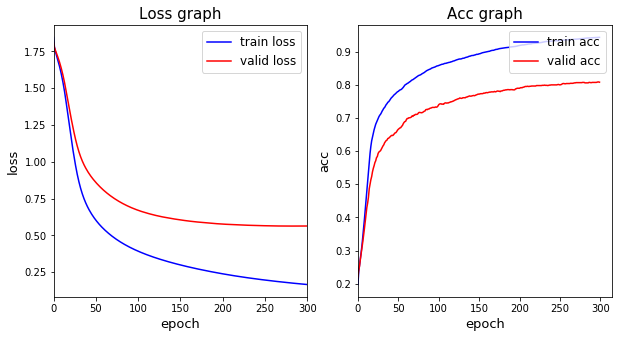

In [38]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [39]:
bestepoch = int(np.argmin(valid_history['loss'].values))
print( bestepoch)

error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

288
error: 0.5628012059985296
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/HAR/HAR_CNN_conv3_1e-05_64/288.ckpt
Model restored


In [40]:
import glob
for epoch in [x+1 for x in range(num_epochs) if (x+1) !=bestepoch]:
    for filename in glob.glob(os.path.join(save_path,model_name,str(epoch)+".*")):
        os.remove(filename) 

### with confusion matrix

In [41]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [42]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

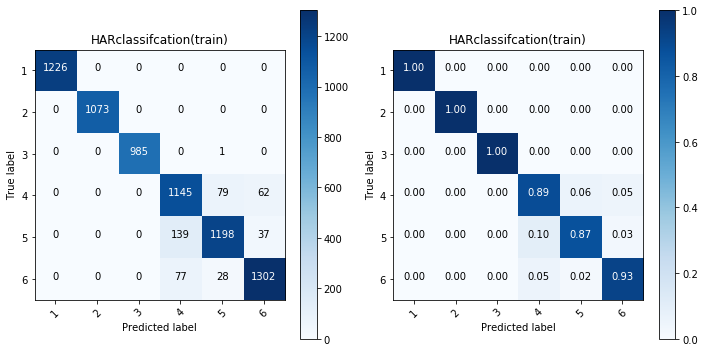

In [43]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,
                                       threshold_weight1 = np.tile(true_threshold_weight1,trainX.shape[0]).T,
                                       threshold_weight2 = np.tile(true_threshold_weight2,trainX.shape[0]).T,
                                        threshold_weight3 = np.tile(true_threshold_weight3,trainX.shape[0]).T)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

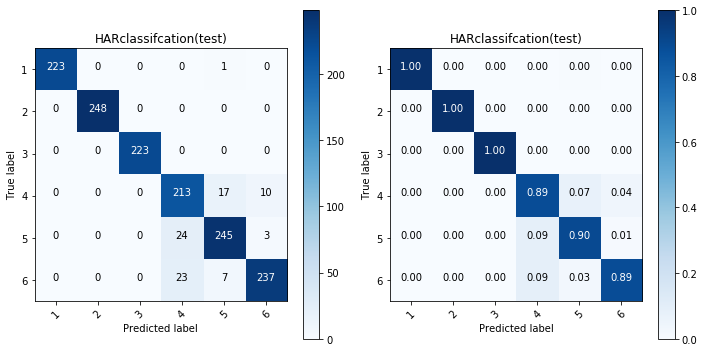

In [44]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,
                                      threshold_weight1 = np.tile(true_threshold_weight1,testX.shape[0]).T,
                                      threshold_weight2 = np.tile(true_threshold_weight2,testX.shape[0]).T,
                                      threshold_weight3 = np.tile(true_threshold_weight3,testX.shape[0]).T)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# MCDROPOUT 적용 VER

In [45]:
import random

In [46]:
mc_num = 1

## 클래스 정하기

np.unique(trainy.flatten())

class_data_idx_bool = np.ones(len(trainy))#(trainy.flatten() ==1) | (trainy.flatten()==3)


class_data_idx = #[i for i,x in enumerate(class_data_idx_bool) if x]

In [47]:
pattern_class = [np.arange(1,nb_classes+1)]

## pattern 추출

last_weight = MC_dropout_model.sess.run([tf.trainable_variables()[-2]],feed_dict={})

In [48]:
pattern_length = np.max([len(x) for x in pool2_idx_list])
dropout_reindexed_relu_bool2=[]
for mc_idx in range(mc_num):
    dropout_relu_output2 = MC_dropout_model.get_output(output = MC_dropout_model.relu2,
                                                data=trainX,keep_prob=1.0,
                                               threshold_weight1 = np.tile(true_threshold_weight1,len(trainX)).T,
                                               threshold_weight2 = np.tile(true_threshold_weight2,len(trainX)).T,
                                               threshold_weight3 = np.tile(true_threshold_weight3,len(trainX)).T)

    #weighted_output2 = np.multiply(np.asarray(last_weight).squeeze().T[pattern_class-1], dropout_relu_output2)
    
    dropout_relu_output2 = dropout_relu_output2.reshape(-1,1,pool2_output_len,conv2_channel)
    temp_threshold2 = np.percentile(dropout_relu_output2,99.5,[0,1,2])
    dropout_relu_bool2 = (dropout_relu_output2>temp_threshold2).squeeze()     
    
    
    for p,data_idx in enumerate(range(len(trainX))):
        for output_c in range(conv2_channel):
            if len([x for x in dropout_relu_bool2[p,:,output_c].flatten() if x]):
                index = []
                for idx in [i for i,x in enumerate(dropout_relu_bool2[p,:,output_c].flatten()) if x]:    
                    dropout_reindexed_relu_bool2.append([data_idx,(mc_idx,output_c),idx])

In [49]:
len(dropout_reindexed_relu_bool2)

32930

### 패턴 중복 count

In [50]:
pattern_idx_df = pd.DataFrame(dropout_reindexed_relu_bool2,columns=["data_idx","output_channel","pattern_xs"])
groups = pattern_idx_df.groupby(["data_idx","pattern_xs"])#["output_channel"].apply(list)

pattern_repetitive_idx_df = groups["output_channel"].apply(list).reset_index(name='output_channel')

consecutive_pattern=[]
pattern_id=0

data_idx = pattern_repetitive_idx_df.loc[:,"data_idx"].values.tolist()
output_channel = pattern_repetitive_idx_df.loc[:,"output_channel"].values.tolist()
pattern_xs = pattern_repetitive_idx_df.loc[:,"pattern_xs"].values.tolist()

for d_idx, output_c,  p_xs in zip(data_idx, output_channel, pattern_xs):
    for input_c in range(trainX.shape[3]):
        pattern_dict={}
        pattern_dict["pattern_id"]= pattern_id
        pattern_dict["data_idx"] = d_idx
        pattern_dict["output_channel"] = output_c
        pattern_dict["input_channel"] = input_c
        pattern_dict["pattern_xs"]= pool2_idx_list[p_xs]
        pattern_dict["survived_output_channel"] = [output_channel for mc, output_channel in output_c]

        short_pattern = pattern_length - len(trainX[d_idx,0,pool2_idx_list[p_xs],input_c])

        if short_pattern:
            if pool2_idx_list[p_xs][0]==0:
                pattern_dict["pattern_ys"] = np.concatenate((np.zeros(short_pattern),(trainX[d_idx,0,pool2_idx_list[p_xs],input_c])))
            else:
                pattern_dict["pattern_ys"] = np.concatenate((trainX[d_idx,0,pool2_idx_list[p_xs],input_c],np.zeros(short_pattern)))
        else:
            pattern_dict["pattern_ys"] = trainX[d_idx,0,pool2_idx_list[p_xs],input_c]

        consecutive_pattern.append(pattern_dict)
        pattern_id+=1

In [51]:
n_cluster=12

In [52]:
main_title = "DROPOUT{}_{}_layer2_final".format(mc_num,data_name)
print(main_title)

DROPOUT1_HAR_layer2_final


In [53]:
np.save('./pattern/{}-0.05%.npy'.format(main_title), consecutive_pattern)

In [54]:
consecutive_pattern = np.load('./pattern/{}-0.05%.npy'.format(main_title),allow_pickle=True)

In [55]:
pattern =[x['pattern_ys'] for x in consecutive_pattern]
pattern_weight = np.asarray([len(x['output_channel']) for x in consecutive_pattern])

In [56]:
len(pattern)

139257

pattern = np.asarray(pattern)[pattern_weight > np.quantile(pattern_weight,0.75)]
consecutive_pattern = np.asarray(consecutive_pattern)[pattern_weight >np.quantile(pattern_weight,0.75)]
pattern_weight = np.asarray(pattern_weight)[pattern_weight >np.quantile(pattern_weight,0.75)]

In [57]:
from sklearn import cluster, mixture

In [64]:
default_base = {'eps': .3,
            'n_clusters': n_cluster}

params = default_base.copy()

params['n_clusters']=n_cluster

k_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
weighted_k_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
#spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'])
#spectral_n = cluster.SpectralClustering(n_clusters=params['n_clusters'],affinity='nearest_neighbor')

clustering_algorithms = (
    ('KMeans', k_means),
    ('MiniBatch_weighted_KMeans', weighted_k_means),
    ('GMM',gmm)
    #('Spectral_RBF', spectral),
    #('Spectral_NN', spectral_n),
    )

#cluster_label_df = pd.DataFrame(index = range(0,len(pattern)))

In [65]:
cluster_label_df= pd.read_csv('./pattern/{}_label'.format(main_title,n_cluster),index_col=0)

In [66]:
for name, algorithm in clustering_algorithms:
    print("{} fitting".format(name))
    if "weighted" in name:
        algorithm.fit(pattern,sample_weight= pattern_weight)
    #elif "Spectral" in name:
    #    algorithm.fit(pattern)
    else:
        algorithm.fit(pattern)

    if hasattr(algorithm, 'labels_'):
        vars()[str(name)+"_pred"] = algorithm.labels_.astype(np.int)
    else:
        vars()[str(name)+"_pred"] = algorithm.predict(pattern)

    cluster_label_df.loc[:,str(name)+"_label"] = eval(str(name)+"_pred")

# cluster_label_df.to_csv('./pattern/{}_label'.format(main_title,n_cluster))

KMeans fitting
MiniBatch_weighted_KMeans fitting
GMM fitting


============================KMeans============================


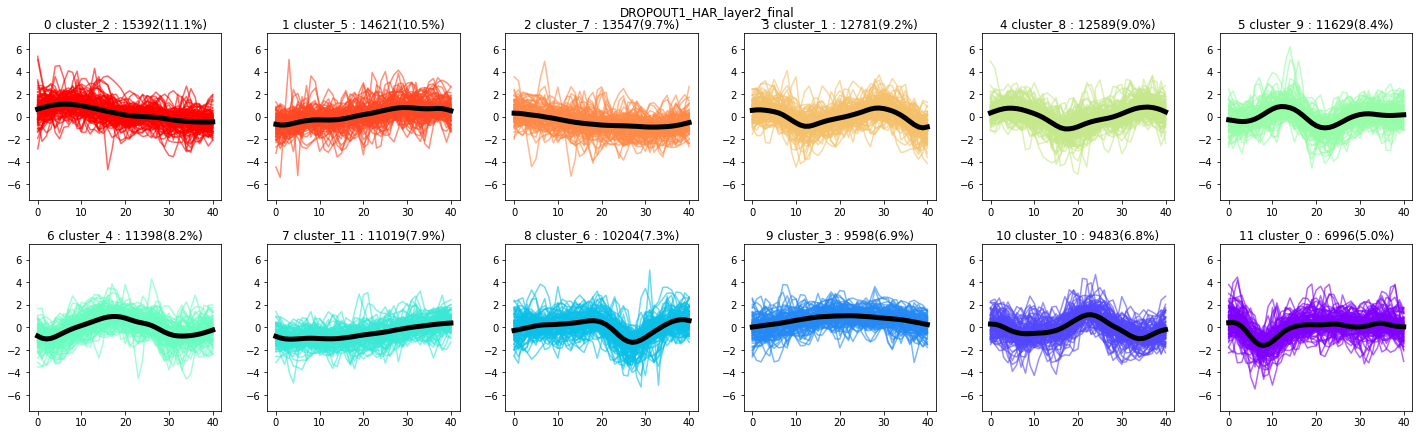

DROPOUT1_HAR_layer2_final saved at ./figure/DROPOUT1_HAR_layer2_final_cluster_KMeans
============================MiniBatch_weighted_KMeans============================


<Figure size 432x288 with 0 Axes>

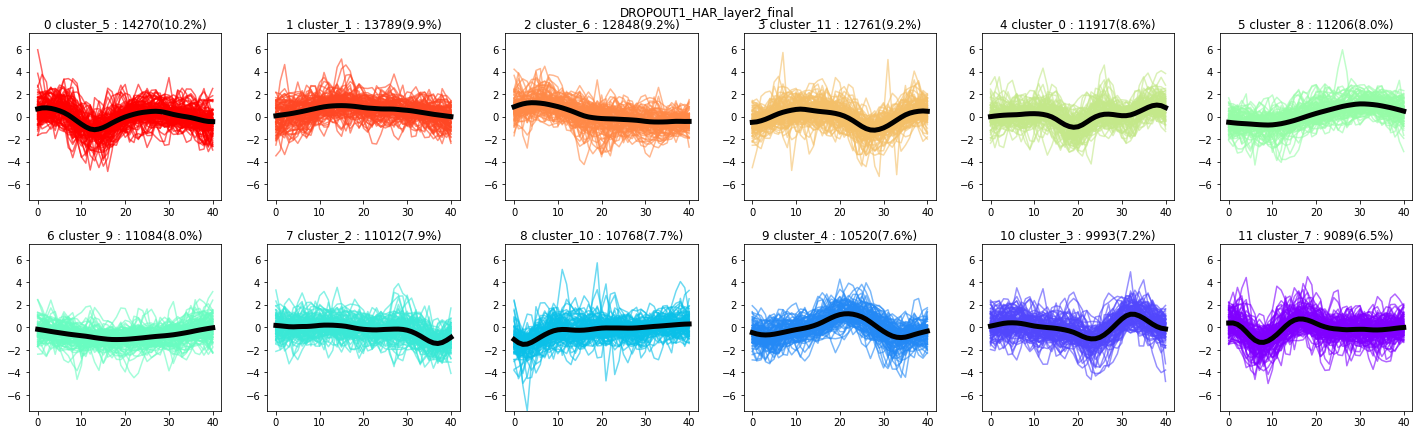

DROPOUT1_HAR_layer2_final saved at ./figure/DROPOUT1_HAR_layer2_final_cluster_MiniBatch_weighted_KMeans
============================GMM============================


<Figure size 432x288 with 0 Axes>

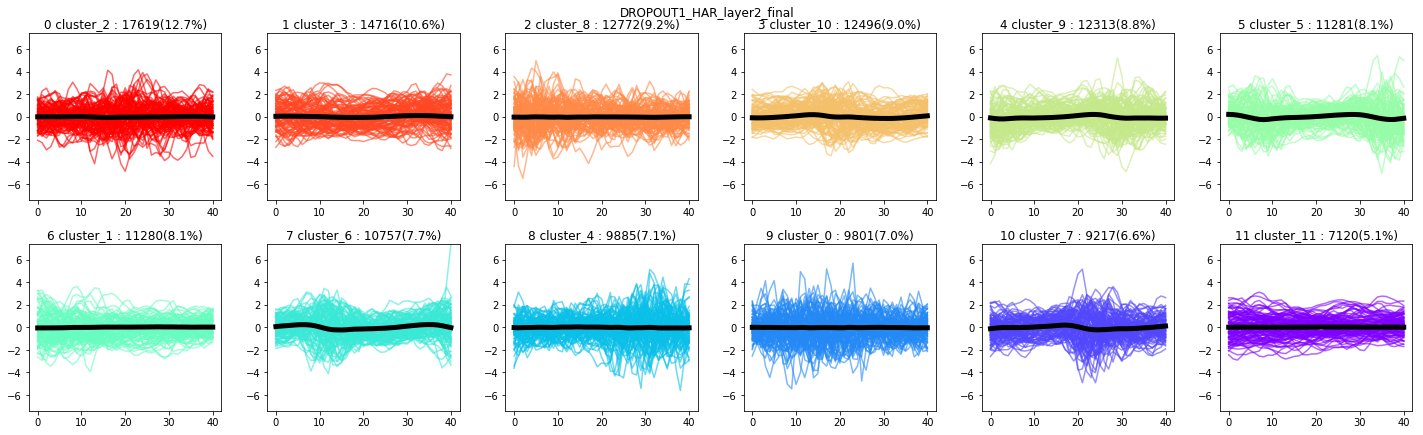

DROPOUT1_HAR_layer2_final saved at ./figure/DROPOUT1_HAR_layer2_final_cluster_GMM


<Figure size 432x288 with 0 Axes>

In [67]:
from matplotlib.pyplot import cm

column=6
color = cm.rainbow(np.linspace(0,1,n_cluster))[::-1]

y_max = np.abs(max(np.min(pattern), np.max(pattern), key=abs))
y_min = -y_max 
cluster_group = []
for name,algorithm in clustering_algorithms:
    fig = plt.figure(figsize=(20,(n_cluster//6*3)))
    save_path = '{}_cluster_{}'.format(main_title, name)
    print("============================"+name+"============================")
    sort_idx = cluster_label_df[name+"_label"].value_counts()
    for n in range(n_cluster): 
        group_idx = [i for i,x in enumerate(eval(str(name)+"_pred")) if x == sort_idx.index[n]]
        group_pattern = np.array([pattern[idx] for idx in group_idx])
        group_pattern_mean = group_pattern.mean(axis=0)
        group_pattern_std = group_pattern.std(axis=0)
        
        if "weighted" in name:
            for g in group_idx:
                consecutive_pattern[g]["group"]=[sort_idx.index[n] for x in range(len(consecutive_pattern[g]["survived_output_channel"]))]
                
            cluster_group.append({"group":sort_idx.index[n],"color_idx":n,
                                  "mean":group_pattern_mean,"std":group_pattern_std})
            
        ax = plt.subplot(n_cluster//column,column,n+1)

        ax.plot(group_pattern[random.sample(range(len(group_pattern)),min(len(group_pattern),100))].T, color =color[n],alpha=0.6)
        ax.plot(group_pattern_mean, color ='black',alpha=1,linewidth=5)

        ax.set_title("{} cluster_{} : {}({:2.1f}%)".format(n, sort_idx.index[n],sort_idx.iloc[n],sort_idx.iloc[n]/len(pattern)*100))
        ax.set_ylim(y_min,y_max) 

    fig.suptitle(main_title,y=1.0,size=12)
    plt.tight_layout()
    plt.show()
    
    plt.savefig(os.path.join('./figure',save_path))
    print("{} saved at {}".format(main_title,os.path.join('./figure',save_path)))
    #plt.close()

============================KMeans============================


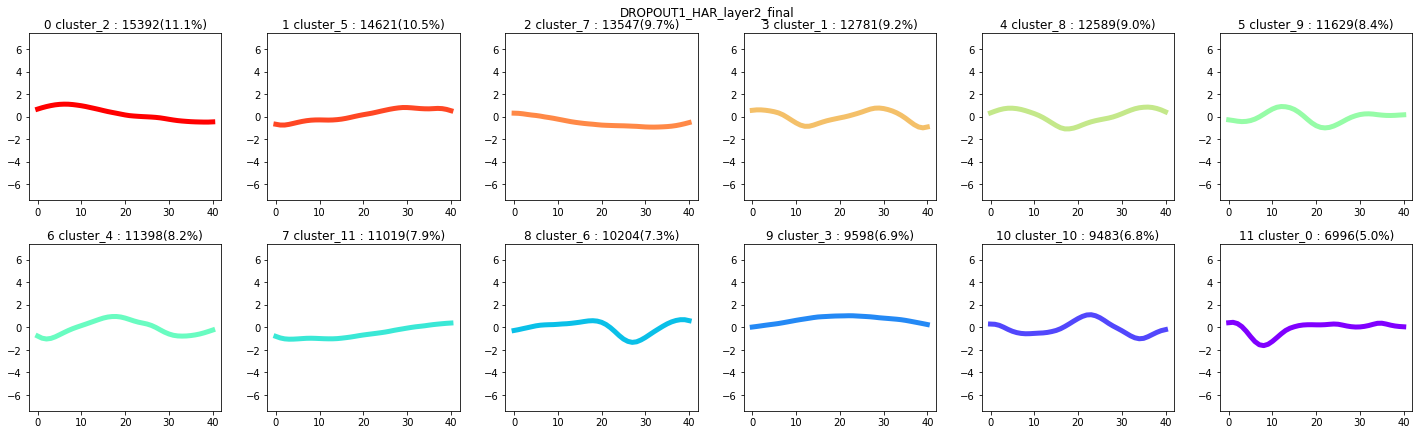

============================MiniBatch_weighted_KMeans============================


In [ ]:
from matplotlib.pyplot import cm

column=6
#color = cm.viridis(np.linspace(0,1,n_cluster))[::-1]

y_max = np.abs(max(np.min(pattern), np.max(pattern), key=abs))
y_min = -y_max 
    
for name,algorithm in clustering_algorithms:
    fig = plt.figure(figsize=(20,(n_cluster//6*3)))
    save_path = '{}_{}_DROPOUT_relu3_cluster{}'.format(name,data_name, n_cluster)
    print("============================"+name+"============================")
    sort_idx = cluster_label_df[name+"_label"].value_counts()
    for n in range(n_cluster): 
        class_idx = [i for i,x in enumerate(eval(str(name)+"_pred")) if x == sort_idx.index[n]]
        class_pattern = np.array([pattern[idx] for idx in class_idx])
        class_pattern_mean = class_pattern.mean(axis=0)

        ax = plt.subplot(n_cluster//column,column,n+1)
        ax.plot(class_pattern_mean, color =color[n],alpha=1,linewidth=5)

        ax.set_title("{} cluster_{} : {}({:2.1f}%)".format(n, sort_idx.index[n],sort_idx.iloc[n],sort_idx.iloc[n]/len(pattern)*100))
        ax.set_ylim(y_min,y_max) 

    fig.suptitle(main_title,y=1.0,size=12)
    plt.tight_layout()
    plt.show()
    
    #plt.savefig(os.path.join('./figure',save_path))
    #print("{} saved at {}".format(main_title,os.path.join('./figure',save_path)))
    #plt.close()

In [ ]:
# from dtwalign import dtw
# from sklearn.preprocessing import MinMaxScaler

# top_dtw_list = []
# column=6
# display_num = 12

# y_max = np.abs(max(np.min(pattern), np.max(pattern), key=abs)) 
# y_min = -y_max 
    
# for group in range(n_cluster):
#     group_idx = [i for i,x in enumerate(cluster_group) if x['group'] == group][0]
#     group_mean = cluster_group[group_idx]['mean']
#     group_color = cluster_group[group_idx]['color_idx']

#     group_patterns = [(x['pattern_id'], x['pattern_xs'],x['pattern_ys'],x['data_idx'],x['input_channel']) for x in consecutive_pattern if x['group'][0]==group]

#     dtw_list=[]
#     for pattern_id, pattern_xs, pattern_ys, data_idx,input_channel in group_patterns:
#         #_ys),np.asarray(group_mean))
#         #res = dtw(pattern_ys,group_mean)
#         res = dtw(pattern_ys,group_mean)
#         dtw_list.append({"pattern_id":pattern_id,"pattern_xs":pattern_xs,"pattern_ys":pattern_ys,"data_idx":data_idx,"input_channel":input_channel,
#                     "group":group, "group_mean":group_mean, "group_color":group_color, "res":res.normalized_distance})
#     dtw_idx = np.argsort([x['res'] for x in dtw_list])       
#     top_dtw_list.append([dtw_list[idx] for idx in dtw_idx[:20]])
    
#     fig = plt.figure(figsize=(20,display_num//2))
#     for n,idx in enumerate(dtw_idx[:display_num]):
        
#         ys = dtw_list[idx]["pattern_ys"]

#         ax = plt.subplot(display_num//column,column,n+1)
#         ax.plot(group_mean, color =color[group_color],alpha=0.5,linewidth=5)
#         ax.plot(ys, alpha=1,linewidth=1)

#         ax.set_title("dtw {:.3f}".format(dtw_list[idx]["res"]))
#         ax.set_ylim(y_min,y_max) 

#     fig.suptitle("Cluster Group {}".format(group),y=1.0,size=12)
#     plt.tight_layout()
#     plt.show()    

### dtw 낮은 패턴을 추출

In [ ]:
many_freq_unit_pattern[57] #1,5

In [ ]:
unit= 57
bool_num =5
unit_pattern = [x for x in consecutive_pattern if unit in x['survived_output_channel']]
dtw_list=[]
top_dtw_list=[]
bottom_dtw_list =[]
for pattern in unit_pattern:
    ys = pattern["pattern_ys"]
    this_group = pattern["group"][0]
    
    #if many_freq_unit_pattern[unit][this_group]: 
    if this_group==bool_num:
        this_group_idx=[i for i,x in enumerate(cluster_group) if x['group'] == this_group][0]
        group_mean = cluster_group[this_group_idx]['mean']
        group_color = cluster_group[this_group_idx]['color_idx']
        res = dtw(ys,group_mean).normalized_distance

        dtw_list.append({"pattern_id":pattern["pattern_id"],"data_idx":pattern["data_idx"],"input_channel":pattern["input_channel"],
                         "pattern_ys":pattern["pattern_ys"],
                        "group":this_group, "group_mean":group_mean, "group_color":group_color, "res":res})

In [ ]:
dtw_idx = np.argsort([x['res'] for x in dtw_list])       
top_dtw_list.append([dtw_list[idx] for idx in dtw_idx[:100]])

In [ ]:
dtw_idx_d = np.argsort([x['res'] for x in dtw_list])[::-1]       
bottom_dtw_list.append([dtw_list[idx] for idx in dtw_idx_d[50:100]])

y_max = 8
y_min = -y_max 

for dic in [top for top in bottom_dtw_list][0]:
    plt.plot(dic['group_mean'], color =color[dic['group_color']], alpha=0.5, linewidth=5)
    plt.plot(dic['pattern_ys'], alpha=1,linewidth=1,color='black')

    plt.title("Group {}, dtw {:.3f}".format(dic['group'], dic['res']))
    plt.ylim(y_min,y_max) 
    plt.show()

    data = trainX[dic['data_idx'],0,:,dic['input_channel']]
    fig, ax= plt.subplots(figsize=(15,3))
    ax.set_xlim([0-10,int(trainX.shape[2])+10])
    ax.set_ylim(y_min-5,y_max+5)
    ax.plot(data,color='black')


    for pattern_id in data_input_idx[dic['data_idx']][dic['input_channel']]:
        group = consecutive_pattern[pattern_id]["group"][0]
        if group==bool_num:
        #if many_freq_unit_pattern[unit][group]:
            xs = consecutive_pattern[pattern_id]["pattern_xs"]
            ys = consecutive_pattern[pattern_id]["pattern_ys"]

            cluster_group_idx = [i for i,x in enumerate(cluster_group) if x['group'] == group][0]
            color_idx = cluster_group[cluster_group_idx]['color_idx']

            ax.plot(xs, ys, ":", color =color[cluster_group_idx] ,alpha=1,linewidth=3)

            mean = np.array(cluster_group[cluster_group_idx]['mean']).reshape(-1,1)
            min_max_scaler = MinMaxScaler(feature_range=(ys.min(), ys.max()))
            pattern_scaled = min_max_scaler.fit_transform(mean).reshape(-1)

            error = np.array(cluster_group[cluster_group_idx]['std'])
            ax.plot(xs, pattern_scaled, color=color[color_idx], alpha=0.6,linewidth=1)
            ax.fill_between(xs, pattern_scaled-0.5*error, pattern_scaled+0.5*error,  color=color[color_idx], alpha=0.5)
            ax.fill_between(xs, pattern_scaled-0.1*error, pattern_scaled+0.1*error, alpha = 0.4, facecolor=color[color_idx])
            ax.fill_between(xs, pattern_scaled-2*error, pattern_scaled+2*error, alpha = 0.2, facecolor=color[color_idx])
    ax.set_title( "CNN Hidden Layer2  |  {} Data {} Inputchannel {}  |  unit{} ".format(data_name, dic['data_idx'],dic['input_channel'],unit), loc='right')
    plt.ylim(y_min,y_max)
    plt.show()



### unit, data, input_channel기준 시각화

In [ ]:
unit = 13
input_channel =  4
data_idx = 5308

y_max = 8
y_min = -y_max 

data = trainX[data_idx,0,:,input_channel]
fig, ax= plt.subplots(figsize=(15,3))
ax.set_xlim([0-10,int(trainX.shape[2])+10])
ax.set_ylim(y_min-5,y_max+5)
ax.plot(data,color='black')

patterns = data_input_idx[data_idx][input_channel]
if type(patterns) == int:
    pattern=[]
    pattern.append(patterns)
    patterns=pattern

for pattern_id in patterns:
    
    #if unit in np.array(consecutive_pattern[pattern_id]["survived_output_channel"]).flatten() : #패턴을 보는 모든 유닛중 해당 유닛이 있는지 보고
    group = consecutive_pattern[pattern_id]["group"][0]
    if many_freq_unit_pattern[unit][group]: # 해당 유닛만 남김
        xs = consecutive_pattern[pattern_id]["pattern_xs"]
        ys = consecutive_pattern[pattern_id]["pattern_ys"]

        cluster_group_idx = [i for i,x in enumerate(cluster_group) if x['group'] == group][0]
        color_idx = cluster_group[cluster_group_idx]['color_idx']

        ax.plot(xs, ys, ":", color =color[cluster_group_idx] ,alpha=1,linewidth=3)

        mean = np.array(cluster_group[cluster_group_idx]['mean']).reshape(-1,1)
        min_max_scaler = MinMaxScaler(feature_range=(ys.min(), ys.max()))
        pattern_scaled = min_max_scaler.fit_transform(mean).reshape(-1)

        error = np.array(cluster_group[cluster_group_idx]['std'])
        ax.plot(xs, pattern_scaled, color=color[color_idx], alpha=0.6,linewidth=1)
        ax.fill_between(xs, pattern_scaled-0.5*error, pattern_scaled+0.5*error,  color=color[color_idx], alpha=0.5)
        ax.fill_between(xs, pattern_scaled-0.1*error, pattern_scaled+0.1*error, alpha = 0.4, facecolor=color[color_idx])
        ax.fill_between(xs, pattern_scaled-2*error, pattern_scaled+2*error, alpha = 0.2, facecolor=color[color_idx])
ax.set_title( "CNN Hidden Layer2  |  {} Data {} Inputchannel {} | unit {} ".format(data_name, data_idx,input_channel,unit), loc='right')
plt.ylim(y_min,y_max)
plt.show()



In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_input_idx = pd.DataFrame.from_records(consecutive_pattern).groupby(['data_idx','input_channel'])['pattern_id'].apply(list)

In [ ]:
from dtwalign import dtw

group = 5
group_idx = [i for i,x in enumerate(cluster_group) if x['group'] == group][0]
group_mean = cluster_group[group_idx]['mean']
group_color = cluster_group[group_idx]['color_idx']

group_patterns = [(x['pattern_id'], x['pattern_xs'],x['pattern_ys'],x['data_idx']) for x in consecutive_pattern if x['group'][0]==group]

dtw_list = []
for pattern_id, pattern_xs, pattern_ys, data_idx in group_patterns:
    #_ys),np.asarray(group_mean))
    #res = dtw(pattern_ys,group_mean)
    res = dtw(pattern_ys,group_mean)
    dtw_list.append({"pattern_id":pattern_id,"pattern_xs":pattern_xs,"pattern_ys":pattern_ys,"data_idx":data_idx,
                "group":group, "group_mean":group_mean, "group_color":group_color, "res":res.normalized_distance})

# unit - pattern set matching with uncertainty measure

In [ ]:
from collections import Counter

In [ ]:
import os

unit_pattern_freq = np.asarray([None]*(n_cluster*conv3_channel)).reshape(conv3_channel, n_cluster)
unit_pattern_std = np.asarray([None]*(n_cluster*conv3_channel)).reshape(conv3_channel, n_cluster)

for unit_idx, mc_idx, cluster in zip(conv3_idxs, mc_idxs,cluster_idxs):  
    temp=[None]*n_cluster
    temp_idx= [i for i,x in enumerate(consecutive_pattern) if ((mc_idx,unit_idx) in x['output_channel'])]
     
    pattern_freq = Counter(cluster_label_df.iloc[:,1].values[temp_idx])
    if pattern_freq[cluster]:
        try:
            temp[cluster].append(pattern_freq[cluster])
        except : 
            temp[cluster]=[pattern_freq[cluster]]
    
    unit_pattern_freq[unit_idx] = [np.mean(x) for x in temp]
    unit_pattern_std[unit_idx] = [np.std(x) for x in temp]
    
    print (unit_idx)

In [ ]:
unit_pattern_freq = np.asarray([None]*(n_cluster*conv2_channel)).reshape(conv2_channel, n_cluster)
unit_pattern_std = np.asarray([None]*(n_cluster*conv2_channel)).reshape(conv2_channel, n_cluster)

for unit_idx in range(conv2_channel):  
    temp=[None]*n_cluster
    for mc_idx in range(mc_num):
        temp_idx= [i for i,x in enumerate(consecutive_pattern) if ((mc_idx,unit_idx) in x['output_channel'])]
        
        pattern_freq = Counter(cluster_label_df.iloc[:,1].values[temp_idx])
        for cluster in range(n_cluster):
            try:
                if cluster in pattern_freq.keys():
                    temp[cluster].append(pattern_freq[cluster])
                else :     
                    temp[cluster].append(0)
            except : 
                temp[cluster]=[pattern_freq[cluster]]
    unit_pattern_freq[unit_idx] = [np.mean(x) for x in temp]
    unit_pattern_std[unit_idx] = [np.std(x) for x in temp]

In [ ]:
unit_pattern_freq_df = pd.DataFrame(unit_pattern_freq)
unit_pattern_std_df = pd.DataFrame(unit_pattern_std)
unit_pattern_freq_df.to_csv('./pattern/{}_unitpattern_freq.csv'.format(main_title))
unit_pattern_std_df.to_csv('./pattern/{}_unitpattern_std.csv'.format(main_title))

In [ ]:
unit_pattern_freq_df =pd.read_csv('./pattern/{}_unitpattern_freq.csv'.format(main_title),index_col=0)
unit_pattern_std_df =pd.read_csv('./pattern/{}_unitpattern_std.csv'.format(main_title),index_col=0)

In [ ]:
many_freq_unit_pattern =  unit_pattern_freq_df.values > np.quantile(np.asarray(unit_pattern_freq_df),0.75,0)

In [ ]:
plt.imshow(many_freq_unit_pattern, vmin=0, vmax=1,aspect='auto')

less_uncetainty_unit_pattern =  unit_pattern_std_df.values < np.quantile(np.asarray(unit_pattern_std_df),0.25,0)

plt.imshow(less_uncetainty_unit_pattern, vmin=0, vmax=1,aspect='auto')

general_unit_pattern = (many_freq_unit_pattern )# & less_uncetainty_unit_pattern)

In [ ]:
## 전체 데이터셋에 relu2 아웃풋이 각 채널에 대해 어떤 클러스터 그룹을 많이 보는지
plt.figure(figsize=[15,20])

focus_unit =[i for i,x in enumerate(many_freq_unit_pattern.sum(axis=1)>0) if x]
im = plt.imshow(many_freq_unit_pattern[focus_unit],interpolation='none', vmin=0, vmax=1, aspect='0.9');

ax = plt.gca();
ax.set_xticks(np.arange(0, n_cluster, 1));
ax.set_yticks(np.arange(0, len(focus_unit) , 1));
ax.set_xticklabels(np.arange(1,n_cluster+1, 1));
ax.set_yticklabels(focus_unit);

# Minor ticks
ax.set_xticks(np.arange(-.5, n_cluster-1, 1), minor=True);
ax.set_yticks(np.arange(-.5, len(focus_unit)-1, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.9)

 # Evaluation of unit-pattern set by IOU score

In [ ]:
pd.DataFrame.from_records(consecutive_pattern).groupby(['data_idx'])['output_channel','group'].agg(lambda x :list(x)).reindex()

In [ ]:
data_unit_list=pd.DataFrame.from_records(consecutive_pattern).groupby(['data_idx'])['survived_output_channel','group'].agg(lambda x :list(x)).reindex()

In [ ]:
data_unit_list

In [ ]:
[6,7,3,2,2].count(5)

In [ ]:
from itertools import chain

unit_group_list_all=[]
IOU_score = []
for n in range(len(data_unit_list)-1):
    
    unit_list = list(chain(*data_unit_list['survived_output_channel'].values[n])) 
    group_list = list(chain(*data_unit_list['group'].values[n]))
    unit_group_list = list(zip(unit_list, group_list))
    unit_group_list_all.extend(np.asarray(list(zip(unit_list, group_list))))
    
    for unit in np.unique(unit_list):
        denorminatior = [x for x in unit_group_list if x[0] == unit]
        numerator = []
        for u,g in denorminatior:
            if many_freq_unit_pattern[u][g]:   
                numerator.append(g)
        
        total_IOU =[]
        each_IOU = []
        true_bool = [i for i, x in enumerate(many_freq_unit_pattern[unit]) if x]
        
        if len(true_bool):        
            for t in true_bool:
                value = numerator.count(t)/len(denorminatior)              
                total_IOU.append(value)
                each_IOU.append({t:value})

            IOU_score.append({"data_idx":data_unit_list.iloc[n].name,"unit":unit,
                              "numerator":numerator,"denorminatior":denorminatior,
                              "each_IOU_core":each_IOU, "IOU_score":np.array(total_IOU).mean(),
                              "true_bool":[i for i, x in enumerate(many_freq_unit_pattern[unit]) if x]})  

In [ ]:
# df = pd.DataFrame(unit_group_list_all,columns=["unit","group"]).groupby(["unit"])["group"].apply(list)

# unit_freq = []
# for n in range(64):
#     print("=======================================================",n,"unit")
#     print(np.unique(df[n], return_counts=True))
#     unit_freq.append(np.unique(df[n], return_counts=True)[1])
    
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(many_freq_unit_pattern, vmin=0, vmax=1,aspect='auto')
# ax[1].imshow(unit_freq,aspect='auto')

In [ ]:
score_idx = np.argsort([x['IOU_score'] for x in IOU_score])[::-1]

In [ ]:
IOU_score[score_idx[999]]

## Visualization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_input_idx = pd.DataFrame.from_records(consecutive_pattern).groupby(['data_idx','input_channel'])['pattern_id'].apply(list)

In [ ]:
def visualization_result(my_num, threshold=0, inchannel_range=range(trainX.shape[-1])):   
    data_idx = IOU_score[my_num]['data_idx']
    unit = IOU_score[my_num]['unit']
    score = IOU_score[my_num]['IOU_score']

    if score > threshold:
        for input_channel in inchannel_range:
            data = trainX[data_idx,0,:,input_channel]

            fig, ax= plt.subplots(figsize=(15,3))
            ax.set_xlim([0-10,int(trainX.shape[2])+10])
            ax.set_ylim(y_min,y_max)
            ax.plot(data,color='black')

            my_group = []

            for pattern_id in data_input_idx[data_idx][input_channel]:
                group = consecutive_pattern[pattern_id]["group"][0]

                if many_freq_unit_pattern[unit][group]:
                    #print("visual",data_idx,input_channel,pattern_id)
                    xs = consecutive_pattern[pattern_id]["pattern_xs"]
                    ys = consecutive_pattern[pattern_id]["pattern_ys"]

                    padding = len(xs) - len(ys)
                    if padding  < 0 :
                        if np.array(xs).max() < pool2_pattern_len : ## left_pading
                            xs = np.concatenate((np.arange(padding,0), np.asarray(xs)))
                        else : 
                            xs = np.concatenate((np.asarray(xs), np.arange(trainX.shape[2],trainX.shape[2]-padding,)))

                    my_group.append(group)
                    cluster_group_idx = [i for i,x in enumerate(cluster_group) if x['group'] == group][0]
                    color_idx = cluster_group[cluster_group_idx]['color_idx']

                    ax.plot(xs, ys, ":", color =color[cluster_group_idx] ,alpha=1,linewidth=3)

                    mean = np.array(cluster_group[cluster_group_idx]['mean']).reshape(-1,1)
                    min_max_scaler = MinMaxScaler(feature_range=(ys.min(), ys.max()))
                    pattern_scaled = min_max_scaler.fit_transform(mean).reshape(-1)

                    error = np.array(cluster_group[cluster_group_idx]['std'])
                    ax.plot(xs, pattern_scaled, color=color[color_idx], alpha=0.6,linewidth=1)
                    ax.fill_between(xs, pattern_scaled-0.5*error, pattern_scaled+0.5*error,  color=color[color_idx], alpha=0.5)
                    ax.fill_between(xs, pattern_scaled-0.1*error, pattern_scaled+0.1*error, alpha = 0.4, facecolor=color[color_idx])
                    ax.fill_between(xs, pattern_scaled-2*error, pattern_scaled+2*error, alpha = 0.2, facecolor=color[color_idx])
            ax.set_title( "CNN Hidden Layer2  |  {} Data {} Inputchannel {}   |    Unit {} IoU={:2.2f}".format(data_name, data_idx,input_channel, unit, score), loc='right')
            plt.show()



In [ ]:
color = cm.viridis(np.linspace(0,1,n_cluster))[::-1]
y_max = np.abs(max(np.min(pattern), np.max(pattern), key=abs))
y_min = -y_max 

In [ ]:
 for n in [i for i, x in enumerate(IOU_score) if x['data_idx']==1980]:
    visualization_result(n, inchannel_range=range(0,1)) 

In [ ]:
for n in range(10):
    visualization_result(score_idx[n])

In [ ]:
for idx in range(4000,42100):
    for n in [i for i, x in enumerate(IOU_score) if x['data_idx']==idx]:
        visualization_result(n, threshold=0.01, inchannel_range=range(0,1)) 

In [ ]:
many_freq_unit_pattern[57]

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.rcParams['axes.grid'] = False

ax = plt.subplot(1,2,1)
ax.imshow(relu_output3[sample_data_idx].T.squeeze(),aspect='auto')

ax = plt.subplot(1,2,2)
ax.imshow(relu_bool3[sample_data_idx].T.squeeze(),aspect='auto',vmin=0,vmax=1)
fig.suptitle("CONV3 OUTPUT\nthreshold: top{}%".format(0.05))

## pattern 추출

### reindexing1

In [ ]:
pattern_length = np.max([len(x) for x in pool3_idx_list])

In [ ]:
reindexed_relu_bool3=[]

for data_idx in sample_data_idx:
    for output_c in range(conv3_channel):
        if len([x for x in relu_bool3[data_idx,:,output_c].flatten() if x]):
            index = []
            for idx in [i for i,x in enumerate(relu_bool3[data_idx,:,output_c].flatten()) if x]:    
                reindexed_relu_bool3.append([data_idx,output_c,idx])

### 패턴 중복 count

In [ ]:
pattern_idx_df = pd.DataFrame(np.asarray(reindexed_relu_bool3),columns=["data_idx","output_channel","pattern_xs"])

In [ ]:
groups = pattern_idx_df.groupby(["data_idx","pattern_xs"])#["output_channel"].apply(list)

In [ ]:
pattern_repetitive_idx_df = groups["output_channel"].apply(list).reset_index(name='output_channel')

In [ ]:
consecutive_pattern=[]
pattern_id=0

data_idx = pattern_repetitive_idx_df.loc[:,"data_idx"].values.tolist()
output_channel = pattern_repetitive_idx_df.loc[:,"output_channel"].values.tolist()
pattern_xs = pattern_repetitive_idx_df.loc[:,"pattern_xs"].values.tolist()

for d_idx, output_c,  p_xs in zip(data_idx, output_channel, pattern_xs):
    for input_c in range(trainX.shape[3]):
        pattern_dict={}
        pattern_dict["pattern_id"]= pattern_id
        pattern_dict["data_idx"] = d_idx
        pattern_dict["output_channel"] = output_c
        pattern_dict["input_channel"] = input_c
        pattern_dict["pattern_xs"]= pool3_idx_list[p_xs]
        
        short_pattern = pattern_length - len(trainX[d_idx,0,pool3_idx_list[p_xs],input_c])
            
        if short_pattern:
            pattern_dict["pattern_ys"] = np.concatenate((trainX[d_idx,0,pool3_idx_list[p_xs],input_c],np.zeros(short_pattern)))
        else:
            pattern_dict["pattern_ys"] = trainX[d_idx,0,pool3_idx_list[p_xs],input_c]
        
        consecutive_pattern.append(pattern_dict)
        pattern_id+=1

# unit- pattern 의 evaluation(with IOU score)

for data_idx in sample_data_idx:
    data_consecutive_pattern =[x for x in consecutive_pattern if x['data_idx']==data_idx]    
    for unit_idx in range(conv3_channel):
        data_unit_pattern = [x['pattern_ys'] for x in data_consecutive_pattern if x['output_channel']==unit_idx]
        if len(data_unit_pattern):
            input_pattern_label = weighted_k_means.predict(data_unit_pattern)
            input_unit_pattern = np.zeros(n_cluster)
            for cluster in Counter(input_pattern_label).keys():
                input_unit_pattern[cluster] = Counter(input_pattern_label)[cluster]
            input_unit_pattern
    break

def conv_IOU(convbool,convbool_list):
    IOU= [(x==convbool).sum()/len(convbool) for x in convbool_list]
    return IOU

relu3_IOU = np.zeros(relu_output3.shape[3]*relu_output3.shape[3]).reshape(relu_output3.shape[3],relu_output3.shape[3])

len(np.zeros(n_cluster*conv3_channel).reshape(conv3_channel, n_cluster))

# 인풋에 대해 unit별 IOU계산

for conv_c1 in range(relu_output3.shape[3]):
    conv2_IOU[conv_c1][:]= conv_IOU(conv2_bool[conv_c1,:],
                                    conv2_bool)

f = plt.figure(figsize=(15,15))
ax = plt.subplot(1,1,1)
sns.heatmap(conv2_IOU, ax = ax, cmap ="OrRd", linewidths = 0.1) 
ax.set_title("IOU scores for CONV2")

#ax2 = plt.subplot(1,2,2)
#sns.heatmap(1.0 - conv2_IOU, ax = ax2, cmap ="OrRd", linewidths = 0.1) 
#ax2.set_title("DISTANCE(1-IOU) scores for CONV2")

import copy

find_same_bool = -np.ones(128).astype(int)

t=0
while (find_same_bool >-1).sum()<128:
    find_same_bool[[i for i,x in enumerate(conv2_IOU[t]) if x==1.0 ]]=t
    t+=1

np.unique(find_same_bool)

unit_cluster_num = len(np.unique(find_same_bool))

fig = plt.figure(figsize=(5,unit_cluster_num))
for i, same_idx in enumerate(np.unique(find_same_bool)):
    ax = plt.subplot(unit_cluster_num,1,i+1)
    ax.imshow(conv2_bool[same_idx].reshape(1,-1).astype(int),aspect="auto",cmap="OrRd",vmin=0, vmax=1)
    ax.set_title("UNIT-CLSUTER{}, \n# of unit in cluster:{}".format((i+1), Counter(find_same_bool)[same_idx]))
    ax.set_yticks([])
plt.tight_layout()

cg = sns.clustermap(conv1_IOU, cmap ="OrRd",
                    linewidths = 0.1, robust=True,
                   metric ="correlation"); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 

Z= cg.dendrogram_col.linkage

from scipy.cluster.hierarchy import fcluster
max_d = 1
clusters = fcluster(Z, max_d, criterion='distance')
clusters

k=50
clusters =fcluster(Z, k, criterion='inconsistent')

clusters

for idx in [i for i,x in enumerate(clusters) if x==8]:
    plt.imshow(conv2_bool[idx].T.reshape(1,-1),aspect="auto", cmap ="OrRd")
    plt.show()

## pick clustering algorithm and apply pattern weighted clustering

consecutive_pattern = np.load('./consecutive_pattern_randomsample(0.2).npy',allow_pickle=True)

# below is ongoing code

import numpy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adagrad
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import ShapeletModel, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

numpy.random.seed(0)

pattern = [pattern[i] for i,x in enumerate(pattern_weight>pattern_weight.mean()) if x]
data_idx = [consecutive_pattern[i]['data_idx'] for i,x in enumerate(pattern_weight>pattern_weight.mean()) if x]
pattern_weight = [pattern_weight[i] for i,x in enumerate(pattern_weight>pattern_weight.mean()) if x]


tempY=np.asarray([trainy[x] for x in data_idx]).flatten()
tempX =np.asarray(pattern).reshape(-1,65,1)

n_ts, ts_sz = tempX.shape[:2]
n_classes = len(set(tempY))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=Adagrad(lr=.1),
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0)
shp_clf.fit(tempX, tempY)
predicted_labels = shp_clf.predict(tempX)
print("Correct classification rate:", accuracy_score(tempY, predicted_labels))

plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()


 from sklearn.preprocessing import MinMaxScaler

predicted_locations = shp_clf.locate(tempX[:10])

test_ts_id = 1
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))
plt.plot(tempX[:10][test_ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[test_ts_id, idx_shp]
    smin = tempX[:10][test_ts_id][t0: t0 + len(shp)].min()
    smax = tempX[:10][test_ts_id][t0: t0 + len(shp)].max()
    
    scaler = MinMaxScaler(feature_range=(smin, smax))
    scaled_shp = scaler.fit_transform(shp)
    
    gap = np.abs(tempX[:10][test_ts_id][t0: t0 + len(shp)] - scaled_shp).mean() /(smax-smin)
    print(gap)
    if gap > 0.18:
        continue
    
    plt.plot(numpy.arange(t0, t0 + len(shp)), scaled_shp, linewidth=2)

plt.tight_layout()
plt.show()

from sklearn import metrics
from sklearn.metrics import pairwise_distances


pseudoF_gmm = []
pseudoF_kmeans = []


cut_num=20

fig = plt.figure(figsize=(20,5))
for n_clusters in range(3,cut_num):
    gmm = mixture.GaussianMixture(n_components=n_clusters, 
            covariance_type='full')
    labels = gmm.fit_predict(normalized_pattern_candidate)
    pseudoF_gmm.append(metrics.calinski_harabasz_score(normalized_pattern_candidate, labels))
    
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0)
    
    labels = kmeans.fit_predict(normalized_pattern_candidate)
    pseudoF_kmeans.append(metrics.calinski_harabasz_score(normalized_pattern_candidate, labels))

x = np.arange(3,cut_num)
ax = plt.subplot(1,2,1)
ax.plot(x, pseudoF_gmm[:cut_num])
ax.set_xticks(x)
ax.set_title("GMM pseudoF score")
plt.grid()

ax = plt.subplot(1,2,2)
ax.plot(x, pseudoF_kmeans[:cut_num])
ax.set_xticks(x)
ax.set_title("Kmeans pseudoF score")
plt.grid()

plt.show()

best_cluster_n = 9

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

random.seed(300)

default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}

g_cluster_pattern_list = []
k_cluster_pattern_list = []

gmm_option = [
    ({'n_clusters': best_cluster_n})
]

kmeans_option = [
    ({'n_clusters': best_cluster_n})
]

for g_option,k_option in zip(gmm_option,kmeans_option):
    g_params = default_gmm.copy()
    g_params.update(g_option)

    k_params = default_kmeans.copy()
    k_params.update(k_option)

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])

    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,6))
    axes = fig.subplots(2, g_params['n_clusters'])

    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        
        g_class_pattern = np.array([normalized_pattern_candidate[idx] for idx in g_class_idx])
        k_class_pattern = np.array([normalized_pattern_candidate[idx] for idx in k_class_idx])

        g_cluster_mean = g_class_pattern.mean(axis=0)
        k_cluster_mean = k_class_pattern.mean(axis=0)

        # visualization
        axes[0,class_].plot(g_class_pattern.T, color =color[class_],alpha=0.6)
        axes[1,class_].plot(k_class_pattern.T, color =color[class_],alpha=0.6)

        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)
        
        # append list
        g_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":g_cluster_mean} for idx in g_class_idx])
        k_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":k_cluster_mean} for idx in k_class_idx])
 

    #("KMeans: {} \nGMM: {}".format(k_params,g_params),y=1.5)
    plt.tight_layout()
    plt.show()

g_class_pattern[random.sample(range())]

### remove outlier pattern for better clustering

다음 알고리즘을 짜기위해 우선 건너뜀

import seaborn as sns 

plt.imshow(pattern_frequency_arr.T,aspect="auto",cmap="OrRd")

pattern_frequency_arr.shape

patt

np.quantile(pattern_frequency_arr,0.75,0).shape

#conv2_bool = (pattern_frequency_arr>np.quantile(pattern_frequency_arr,0.75,0)).T



plt.imshow(conv2_bool,aspect="auto",cmap="OrRd")

## turn off unit

MC_dropout_model.relu2.shape

plt.imshow(unit_bool[0].squeeze())

np.unique(find_same_bool)[0]

each_clustering_turnoff=[original_acc]
for same_idx in np.unique(find_same_bool):
    unit_bool =copy.deepcopy(true_bool)
    for idx in [i for i,x in enumerate(find_same_bool) if x==same_idx]:
        unit_bool[:,:,:,idx] = False
    acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.threshold_weight1 :np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                    MC_dropout_model.threshold_weight2 :unit_bool})
    each_clustering_turnoff.append(acc)
    
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1,)
ax.scatter(0,original_acc,c='r',s=40)
ax.set_xticks(np.arange(0,unit_cluster_num+1))
ax.plot(each_clustering_turnoff,c='black')
ax.axhline(original_acc, c='r')
ax.set_xlabel("UNIT CLUSTERING ID")
ax.set_ylabel("ACCURACY")
plt.grid()
fig.suptitle("ACCURACY WHEN UNIT-CLUSTRING IS TURNED OFF ")

same_idx = np.unique(find_same_bool)[5]
unit_bool =copy.deepcopy(true_bool)
for idx in [i for i,x in enumerate(find_same_bool) if x==same_idx]:
    unit_bool[:,:,:,idx] = False
acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                      feed_dict={MC_dropout_model.x: trainX,
                                 MC_dropout_model.y: trainY,
                                MC_dropout_model.keep_prob:1.0,
                                MC_dropout_model.threshold_weight1 :np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                MC_dropout_model.threshold_weight2 :unit_bool})

each_clustering_turnon=[original_acc]
for same_idx in np.unique(find_same_bool):
    unit_bool =copy.deepcopy(false_bool)
    for idx in [i for i,x in enumerate(find_same_bool) if x==same_idx]:
        unit_bool[:,:,:,idx] = True
    acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.threshold_weight1 :np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                    MC_dropout_model.threshold_weight2 :unit_bool})
    each_clustering_turnon.append(acc)
    
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1,)
ax.scatter(0,original_acc,c='r',s=40)
ax.set_xticks(np.arange(0,unit_cluster_num+1))
ax.plot(each_clustering_turnon,c='black')
ax.axhline(original_acc, c='r')
ax.set_xlabel("UNIT CLUSTERING ID")
ax.set_ylabel("ACCURACY")
plt.grid()
fig.suptitle("ACCURACY WHEN UNIT-CLUSTRING IS TURNED ON ")

# clustering

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

n_clusters = 6

# clustering with fixed length data

1. 패턴의 길이를 fix하고 해당 length의 패턴만을 클러스터링

pattern_len = 6
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if len(x['pattern_idx']) ==pattern_len]
specific_pattern=[x['pattern'] for i,x in enumerate(consecutive_pattern) if i in specific_len_pattern_idx]
len(specific_len_pattern_idx)

## pattern standardization
1. 평균0, 분산1 형태로 standardization

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform(specific_pattern)
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

## spectral clustering, gmm clustering,k-means,SOM

from sklearn import mixture,cluster
from tslearn.clustering import TimeSeriesKMeans

#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’
default_spectral = {'n_clusters':2,
                    'eigen_solver': 'arpack',
                    'affinity': "rbf"}

#covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}
default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

spectral_option = [
    ({'n_clusters': 6})
]

gmm_option = [
    ({'n_clusters': 6})
    
]

kmeans_option = [
    ({'n_clusters': 6})
    
]

hac_option =[
    ({'cut_off_level': 6})
    
]

import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

random.seed(300)
for g_option,k_option in zip(gmm_option,kmeans_option):

    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)
    
    g_cluster_mean_pattern =[]
    k_cluster_mean_pattern =[]

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,7))
    axes = fig.subplots(2, g_params['n_clusters'])
    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]

        try:
            axes[0,class_].plot(normalized_pattern_candidate[random.sample(g_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[random.sample(k_class_idx,30)].T, color =color[class_],alpha=0.6)

        except:
            axes[0,class_].plot(normalized_pattern_candidate[g_class_idx].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[k_class_idx].T, color =color[class_],alpha=0.6)

        g_cluster_mean = normalized_pattern_candidate[g_class_idx].mean(axis=0)
        g_cluster_mean_pattern.append(g_cluster_mean)
        k_cluster_mean = normalized_pattern_candidate[k_class_idx].mean(axis=0)
        k_cluster_mean_pattern.append(k_cluster_mean)
        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)

    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()

import more_itertools as mit
from sklearn.preprocessing import MinMaxScaler

prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False,threshold_weight = np.ones(trainX.shape[0]*128*128).reshape(-1,1,128,128))

#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_idx= list(set(specific_data_pattern_idx) & set(specific_len_pattern_idx))
    specific_pattern_info = [consecutive_pattern[x] for x in specific_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==15:
        break
    
    for p_idx,p_info in zip(specific_pattern_idx, specific_pattern_info):
        plot_idx+=1
        # 데이터 자체 그리기
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        data = trainX[d_idx,0,:,input_pattern_channel]
        ax.plot(data,color='black')
        
        highlight_bool = np.zeros(width).astype(bool)
        for p_channel in p_info['pattern_channel']:
            hightlight_bool = (highlight_bool | last_conv_bool[d_idx,:,p_channel])
        
        
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(hightlight_bool) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)

        color_idx = g_pred[specific_len_pattern_idx.index(p_idx)]
        pattern_idx = p_info['pattern_idx']
        ax.plot(pattern_idx, data[pattern_idx], color = color[color_idx])

        # 패턴의 평균값 굵고 투명하게 그리기
        x = g_cluster_mean_pattern[color_idx].reshape(-1,1) #returns a numpy array
        min_max_scaler = MinMaxScaler(feature_range=(data[pattern_idx].min(), data[pattern_idx].max()))
        pattern_scaled = min_max_scaler.fit_transform(x)
        ax.plot(pattern_idx, pattern_scaled, color = color[color_idx], alpha=0.4,linewidth=10)
        fig.suptitle("data{} : label{}, prediction{} \n in last conv output_channel{}".format(d_idx, np.argmax(trainY[d_idx]),np.argmax(prediction[d_idx]),p_info['pattern_channel']),y=1.0)
    plt.show()
    

## clustering with different length scale

#### Global Alignmnet Kernel K Means

pattern_len = 6
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern)]
specific_pattern=[x['pattern'] for i,x in enumerate(consecutive_pattern) if i in specific_len_pattern_idx]
len(specific_len_pattern_idx)

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import GlobalAlignmentKernelKMeans

#길이를 맞추기위해 nan으로 패딩
X =to_time_series_dataset(specific_pattern)

gak_km = GlobalAlignmentKernelKMeans(n_clusters=n_clusters)
gak_km_predict = gak_km.fit_predict(X)

class_breakdown(gak_km_predict)

for n in range(n_clusters):
    idx = [i for i,x in enumerate(gak_km_predict) if x==n]
    vars()["pattern_"+str(n)] = [pattern[i] for i in idx ]

plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    for p in eval("pattern_"+str(n)):
        ax.plot(range(len(p)),p,color = color[n])
plt.tight_layout()

plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    mindexes = [np.argmax(x) for x in eval("pattern_"+str(n))]
    vars()["norm_pattern_"+str(n)] = [(x-min(x)) for x in eval("pattern_"+str(n))]
    for i,p in enumerate(eval("norm_pattern_"+str(n))):
        shifts = max(mindexes) - mindexes[i]
        ax.plot(range(shifts,shifts+len(p)), p,color=color[n],alpha=0.2)

plt.show()

### find representative shape for each clustering

#### 1. Using U shapelet
ref: Clustering Time Series using Unsupervised-Shapelets

len(pattern)

import copy
sLen = range(5,9)
D=copy.deepcopy(pattern)

S_hat=[]
ts=D[50]
for _ in range(10):
    cnt=0 #count of candidate u-shapelets from ts
    s_hat ={} #set of subsequences, initially empty
    gap = []
    dt =[]
        
    for sl in sLen:#each u-shapelet length
        for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
            s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
            tup = compute_gap(s_hat[cnt],D,6)
            gap.append(tup[0])
            dt.append(tup[1])
            cnt+=1
    if cnt>0:
        index1 = np.argmax(gap)
        S_hat.append(s_hat[index1]) #find maximum gap score
        dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score
        try:
            dA= [dis[i] for i,x in enumerate(dis<dt[index1]) if x==True] #points to the left of dt
        except:
            dA = [dis[i] for i,x in enumerate(dis) if x<dt[0]]

        if len(dA) ==1:
            print("dA length:1")
            break
        else:
            index2 = np.argmax(dis)
            ts = D[index2]
            msdA= np.mean(dA) +np.std(dA)
            D_hat = [i for i,x in enumerate(dis<msdA) if x ==True]
            idx = [x for x in np.arange(0,len(D)) if x not in D_hat]
            new_D=[]
            for d_idx in idx:
                new_D.append(D[d_idx])
            D=new_D

def znorm(data):
    return (data-min(data))/(max(data)-min(data))

def euclidean_d(data1,data2):
    return np.linalg.norm(data1-data2)

def compute_gap(sub, data,cluster_num):
    dis= compute_distance(sub,data)
    dis = np.sort(dis)
    maxGap = 0
    dt = 0
    for l in range(1, len(dis)-1):
        d = (dis[l]+dis[l+1])/2

        dA = dis[dis<d]
        dB = dis[dis>d]
        try:
            r = len(dA)/len(dB)
            if ((1/cluster_num < r) and (1-(1/cluster_num))):
                mA = dA.mean()
                mB = dB.mean()
                sA = dA.std()
                sB = dB.std()
                gap = mB-sB-(mA+sA)
                if gap > maxGap :
                    #print("gap {}".format(gap))
                    maxGap =gap
                    dt =d
        except:
            pass
    return maxGap, dt

def compute_distance(sub, data):
    dis=[10e3]*len(data)
    sub = znorm(sub)
    for i in range(0,len(data)):
        ts = data[i]

        for j in range(0, len(ts)-len(sub)):
            z = znorm(ts[j:j+len(sub)])
            d = euclidean_d(z,sub)
            dis[i]= min(d,dis[i])/np.sqrt(len(sub))
        #print(dis[i])
    return dis

#### 2. Use dtw measure

from dtwalign import dtw

x = norm_pattern_5[60]
y = norm_pattern_5[0]
res = dtw(x,y)

# dtw distance
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

"""
if you want to calculate only dtw distance (i.e. no need to gain alignment path),
give 'distance_only' argument as True (it makes faster).
"""
#res = dtw(x,y,distance_only=True)


ax = plt.subplot(2,1,1)
ax.plot(x,color="blue")
ax.plot(y,color="red")
ax.set_ylim(0,1)
# warp both x and y by alignment path
x_path = res.path[:,0]
y_path = res.path[:,1]

ax = plt.subplot(2,1,2)
ax.plot(x[x_path],label="aligned query",color="blue")
ax.plot(y[y_path],label="aligned reference",color="red")
ax.legend()
ax.set_ylim(0,1)

# visualize alignment path with cumsum cost matrix
res.plot_path()

prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)

#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_info = [consecutive_pattern[x] for x in specific_data_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==5:
        break
    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']== p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_data_pattern_idx[idx]
            color_idx = gak_km_predict[specific_data_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,consecutive_pattern[pattern_idx]['pattern_channel']))
        break

        
    plt.show()

# Below part is still unclear

f = open('file.txt', 'a+t')
for i,x in enumerate(X):
    for x_ in x:
        f.write(str(x_[0])+",")
    f.write(":"+str(gak_km_predict[i])+"\n")

f.close()      

X_df = pd.DataFrame(columns=["dim_0"],index=range(len(X)))
for i,x in enumerate(X):
    X_df.iloc[i,0] = x

Y_df =gak_km_predict.astype('<U1')

from sktime.transformers.shapelets import ContractedShapeletTransform
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_limit_in_mins = 1

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
initial_num_shapelets_per_case = 5

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_limit_in_mins=time_limit_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(X_df, Y_df)

# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(
        X[s.series_id],
        'gray'
    )

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        X[s.series_id,s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

## hierarchical clustering

import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

D = hac.linkage(normalized_pattern_candidate[:20], method='single',metric='euclidean')
cut_off_level = 5
#Dendrogram
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
plt.xlabel('sample index', fontsize=25, fontweight='bold')
plt.ylabel('distance', fontsize=25, fontweight='bold')
hac.dendrogram(D, leaf_rotation=90., leaf_font_size=15., ) # font size for the x axis labels
plt.show()

특정 파라미터에 해당하는 클러스터 시각화

import matplotlib.patheffects as pe

random.seed(300)
sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),len(normalized_pattern_candidate))
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

for s_option,g_option,k_option in zip(spectral_option[::-1],gmm_option[::-1],kmeans_option[::-1]):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    spectral.fit(normalized_pattern_candidate)
    gmm.fit(normalized_pattern_candidate)
    kmeans.fit(normalized_pattern_candidate)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    k_pred = kmeans.fit_predict(normalized_pattern_candidate[sample_data_idx])
    
    num_class = len(list(set(np.unique(s_pred)).union(set(np.unique(g_pred)))))
    fig = plt.figure(figsize=(18,5))
    axes = fig.subplots(3,num_class)    
    
    for class_ in range(0,num_class):
        class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        try:
            axes[0][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[0][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color = 'black',alpha=1,linewidth=3,
                   path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        
        class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        try:
            axes[1][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[1][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        try:
            axes[2][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[2][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()
    break

### 2. clustering time series using unsupervised shapelets

D =pattern.copy(deep=True)
sLen = range(6,32)

S_hat={}
ts =D[500]

len(pattern)

s_option =spectral_option[-1]
g_option=gmm_option[-1]
s_params = default_spectral.copy()
s_params.update(s_option)

g_params = default_gmm.copy()
g_params.update(g_option)

spectral = cluster.SpectralClustering(
    n_clusters=s_params['n_clusters'], 
    eigen_solver=s_params['eigen_solver'],
    affinity=s_params['affinity'])

gmm =  mixture.GaussianMixture(
    n_components=g_params['n_clusters'], 
    covariance_type=g_params['covariance_type'])

s_pred = spectral.fit_predict(normalized_pattern_candidate)
g_pred = gmm.fit_predict(normalized_pattern_candidate)

s_representative_pattern =[]
g_representative_pattern =[]
for class_ in np.unique(s_pred):

    s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
    s_representative_pattern.append(normalized_pattern_candidate[s_class_idx].mean(axis=0))

    g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
    g_representative_pattern.append(normalized_pattern_candidate[g_class_idx].mean(axis=0))


from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 2, 1,projection='3d')

x = ((g_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((g_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((g_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax.scatter(x,y,z, c = g_pred)

ax.set_xlabel('class1')
ax.set_ylabel('class2')
ax.set_zlabel('class3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.axis('off')

ax2 = fig.add_subplot(1, 2, 2,projection='3d')

x = ((s_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((s_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((s_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax2.scatter(x,y,z, c = s_pred)

ax2.set_xlabel('class1')
ax2.set_ylabel('class2')
ax2.set_zlabel('class3')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option in zip(spectral_option,gmm_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    s_pred = spectral.fit(normalized_pattern_candidate)
    g_pred = gmm.fit(normalized_pattern_candidate)
    
    sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),100)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    
    fig = plt.figure(figsize=(15,3))
    for class_ in np.unique(s_pred):
        ax = plt.subplot(1,2,1)
        class_idx = [sample_data_idx[i] for i,x in enumerate(s_pred) if x ==class_]
        ax.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
        ax.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)

        ax2 = plt.subplot(1,2,2)
        class_idx = [sample_data_idx[i] for i,x in enumerate(g_pred) if x ==class_]
        try:
            #ax2.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
            ax2.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)
        except:
            continue

    fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params))
    plt.tight_layout()


### plotly visualization을 위해 샘플 데이터 및 패턴 저장

sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

## 2d visualization

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

## 3d visualization

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%matplotlib qt

random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                #ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.2, 1]))
    break